In [1]:
import os
import sys
import traceback
from time import time
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pygraphviz as pgv

import torch  # for uniformity we will use pytorch 

import networkx as nx
import dgl

# Globals
SEED=314

# Change to 'False' if using AWS
LOCAL=True

If references are needed for some of the packages we will be using, please feel free to ask to setup a KT session or look at some of the resources below:

[PyTorch](https://pytorch.org/tutorials/)<br>
[DGL (Deep Graph Library)](https://docs.dgl.ai/tutorials/blitz/index.html)<br>
[GraphViz](https://renenyffenegger.ch/notes/tools/Graphviz/examples/index)<br>
[UMAP (Uniform Manifold Approximation & Projection)](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)

# Data loading

In [2]:
# Not great, will improve packaging
sys.path.append('../src')

import utils.data as tmd
import tmgraph as tmg

In [3]:
if LOCAL:
    try:
        aml_data, G = tmd.get_aml_graph_local('../data/10Kvertices-1Medges')
        print('Aggregating customer accounts...')
        aml_data.agg_customer_accounts()
        print('[PROCESS COMPLETE]')
    except AssertionError:
        print(sys.exc_info()[1])
        print("""Did not find 10Kvertices-1Medges in the data folder...
Have you run 'bash setup.sh' or 'bash setup/get_data.sh'?""")
    except:
        print(sys.exc_info()[1])
        traceback.print_tb(sys.exc_info()[2])
else:
    # Not implemented, will throw error
    tmd.get_aml_graph_s3()

Loading data...
Loaded:
	10000 accounts
	1323234 transactions
	1719 alerts
	Loaded in: 0.5671s
Preparing graph object...


/home/dalton/.local/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


Graph created...
Building transaction ledger...
Aggregating customer accounts...
[PROCESS COMPLETE]


# Quick functionality demo

In [4]:
# We check how many timesteps are in our ledger
len(aml_data.ledger)

200

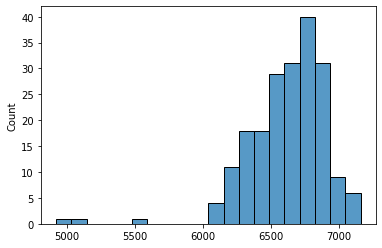

In [5]:
# Let's look at the distribution of transactions per timestep
sns.histplot([c['TX_ID'].shape[0] for c in aml_data.ledger.values()])
plt.show()

In [6]:
# The TMGraph object is built to help facilitate using temporal data in a way that is similar
# to how many reinforcement learning environment objects are setup
env = tmg.TMGraph(G, aml_data.ledger)

In [7]:
# We take a look at the some random accounts at t=0
ACCOUNTS = np.random.randint(1,len(aml_data.accounts),(10,))
pd.DataFrame().from_dict({k: v.numpy() for k, v in env.transaction_graph.nodes[ACCOUNTS].data.items()}, orient='index', columns=ACCOUNTS)

,6945,2189,3722,9905,1640,3269,8948,2900,6264,1007
BALANCE,350.84,128.78,131.21,208.02,143.4,329.22,258.23,239.85,263.6,194.98
COUNTRY,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00
ACCOUNT_TYPE,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00


In [8]:
# Since we are at state=0 before transaction step 0, there should be no edges
env.transaction_graph.edata

{}

In [9]:
# We take a step!
print(f"t = {env.t}")
print(f"\tNumber of transactions: {len(env.transaction_ledger[0]['TX_ID'])}")
start = time()
env.step()
end = time()-start
print(f"t = {env.t}")
print(f"\tTime to step: {round(end,5)}s")

t = 0
	Number of transactions: 4920
t = 1
	Time to step: 0.00121s


In [10]:
# We look at the data for the same accounts after the step.
# If no account balances changed, it means none of the 
# 10 accounts were invloved in a transaction at this time
pd.DataFrame().from_dict({k: v.numpy() for k, v in env.transaction_graph.nodes[ACCOUNTS].data.items()}, orient='index', columns=ACCOUNTS)

,6945,2189,3722,9905,1640,3269,8948,2900,6264,1007
BALANCE,371.29,281.54,131.21,341.57,270.67,329.22,258.23,239.85,409.85,155.99
COUNTRY,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ACCOUNT_TYPE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [11]:
# We check the edges now
env.transaction_graph.edata

{'TX_ID': tensor([   1,    2,    3,  ..., 4918, 4919, 4920]), 'TIMESTAMP': tensor([0, 0, 0,  ..., 0, 0, 0]), 'TX_AMOUNT': tensor([465.0500, 564.6400, 598.9400,  ..., 496.8600, 561.1000, 522.2800],
       dtype=torch.float64), 'TX_TYPE': tensor([0, 0, 0,  ..., 0, 0, 0])}

In [12]:
# Now we see that it works, let's reset the graph, check the reset, and check how
# long it takes to run all 200 time steps
env.reset()
assert env.t == 0
assert env.transaction_graph.edata == {}
print("Graph reset!")

Graph reset!


In [13]:
start = time()
for i in env.transaction_ledger.keys():
    env.step()
end = time()-start
print(f"{round(end,4)}s for {env.transaction_graph.num_edges()} transactions")

0.753s for 1323234 transactions


In [14]:
# Let's reset the graph, check the reset, and move on
env.reset()
assert env.t == 0
assert env.transaction_graph.edata == {}
print("Graph reset!")

Graph reset!


# Some simple subgraph techniques

In [ ]:
# We will grab an account (258) that is associated with an alert
# An alert is raised for this at timestep 42 so we need to increment
# the environment to at least t=42
account_of_interest = 258

for _ in range(42):
    env.step()

print(env.t)

In [ ]:
# We collect the n-community (subgraph with nodes separated by at most n edges)
# centered around the account we are investigating
account_node = torch.tensor([account_of_interest], dtype=torch.int64)
communities = {0: {'nodes': account_node,
                   'subgraph': env.transaction_graph.subgraph(account_node)
                  }}
separation = 2

for sep in range(1,separation+1):
    _ , successors = env.transaction_graph.out_edges(communities[sep-1]['nodes'])
    new_sources = torch.unique(successors)
    communities.update({sep: {'nodes': torch.cat([communities[sep-1]['nodes'], new_sources]),
                              'subgraph': env.transaction_graph.subgraph(new_sources)
                             }
                       }
                      )